In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time

import numpy as np
from multiprocess import Pool

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

%matplotlib inline

Setting environment for Precision WorkStation


No vtk
No vtkNot using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# stack = 'ChatCryoJane201710'
stack = 'MD661'
first_sec, last_sec = metadata_cache['section_limits'][stack]

In [4]:
batch_size = 256
model_dir_name = 'inception-bn-blue'
model_name = 'inception-bn-blue'
model, mean_img = load_mxnet_model(model_dir_name=model_dir_name, model_name=model_name, 
                                   num_gpus=1, batch_size=batch_size)

/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [5]:
clfs = DataManager.load_classifiers(classifier_id=999)
# clfs = {'7N': clfs['7N']}

In [ ]:
for sec in metadata_cache['valid_sections'][stack]:
# for sec in [106]:
    
#     for structure in clfs.keys():
#     for structure in ['DC', '5N', '3N', 'Pn', '10N', 'LC', '7N', 'Amb', '12N', 'RMC', 'Sp5O', 'Sp5I', 'Sp5C', 'VCP', 'AP', 'PBG', 'LRt', 'IC', 'VLL', '4N', 'SNC', '6N', 'SNR', 'SC', 'RtTg']:

    out_resolution_um = 10.

    viz_all_landmarks, scoremap_all_landmarks = draw_scoremap(clfs=clfs, 
                            scheme='normalize_mu_region_sigma_wholeImage_(-1,5)', 
#                                 scheme='none', 
#                             bbox=(11217, 16886, 13859, 18404),
                            win_id=7,
                            stack=stack, return_scoremap=True, sec=sec,
                            model=model, model_name=model_name,
                             mean_img=mean_img, 
                             batch_size=batch_size,
                           out_resolution_um=out_resolution_um)

    for name_u in clfs.keys():
#     for name_u in ['7N']:
        
        sm = scoremap_all_landmarks[name_u]
        viz = viz_all_landmarks[name_u]
    
        scoremap_bp_filepath = \
        DataManager.get_downscaled_scoremap_filepath(stack=stack, section=sec, 
                                                     structure=name_u,
                                                     detector_id=999,
                                                     out_resolution_um=out_resolution_um)

        create_parent_dir_if_not_exists(scoremap_bp_filepath)
        bp.pack_ndarray_file(sm.astype(np.float16), scoremap_bp_filepath)
        upload_to_s3(scoremap_bp_filepath)


        viz_filepath = \
        DataManager.get_scoremap_viz_filepath_v2(stack=stack, section=sec, 
                                                     structure=name_u,
                                                     detector_id=999,
                                                     out_resolution_um=out_resolution_um)

        create_parent_dir_if_not_exists(viz_filepath)
        imsave(viz_filepath, viz)
        upload_to_s3(viz_filepath)

    del viz_all_landmarks, scoremap_all_landmarks

locate patches: 0.08 seconds
Load pre-computed features: 0.95 seconds
Not using image_cache.
Load background image: 2.90 seconds
/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
Rescale background image to output resolution: 4.38 seconds
Predict scores Tz: 0.15 seconds
Rescample scoremap Tz: 0.09 seconds
Load and rescale background image: 0.00 seconds
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
Generate scoremap overlay: 0.12 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.31 seconds
Predict scores VCA: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap VCA: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.14 seconds
Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.13 seconds
Rescample scoremap DC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.13 seconds
Rescample scoremap 5N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.13 seconds
Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.13 seconds
Rescample scoremap Pn: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.26 seconds
Predict scores LC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.25 seconds
Predict scores 7N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds
Predict scores Amb: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Amb: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.27 seconds
Predict scores 12N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 12N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.27 seconds
Predict scores RMC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap RMC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.26 seconds
Predict scores Sp5O: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Sp5O: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds
Predict scores Sp5I: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Sp5I: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.27 seconds
Predict scores Sp5C: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Sp5C: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds
Predict scores VCP: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap VCP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.15 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds
Predict scores PBG: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap PBG: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.26 seconds
Predict scores LRt: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.15 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds
Predict scores VLL: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap VLL: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VLL: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.16 seconds
Rescample scoremap 4N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.13 seconds
Rescample scoremap SNC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.15 seconds
Rescample scoremap 6N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.13 seconds
Rescample scoremap SNR: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.15 seconds
Rescample scoremap SC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.27 seconds
Predict scores RtTg: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap RtTg: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_10.0um_detector999/MD662&661-F30-

locate patches: 0.06 seconds
Load pre-computed features: 1.02 seconds
Not using image_cache.
Load background image: 2.76 seconds
Rescale background image to output resolution: 4.56 seconds
Predict scores Tz: 0.15 seconds
Rescample scoremap Tz: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds
Predict scores VCA: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap VCA: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.27 seconds
Predict scores 7n: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds
Predict scores DC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap DC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.27 seconds
Predict scores 5N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 5N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds
Predict scores 3N: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds
Predict scores Pn: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Pn: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.27 seconds
Predict scores 10N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 10N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.16 seconds
Rescample scoremap LC: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds
Predict scores 7N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.26 seconds
Predict scores Amb: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Amb: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.27 seconds
Predict scores 12N: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 12N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.15 seconds
Rescample scoremap RMC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.26 seconds
Predict scores Sp5O: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Sp5O: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds
Predict scores Sp5I: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Sp5I: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.27 seconds
Predict scores Sp5C: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds
Predict scores VCP: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap VCP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds
Predict scores AP: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap AP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.26 seconds
Predict scores PBG: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap PBG: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.26 seconds
Predict scores LRt: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap LRt: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds
Predict scores IC: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap IC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds
Predict scores VLL: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap VLL: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds
Predict scores 4N: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 4N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds
Predict scores SNC: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap SNC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds
Predict scores 6N: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 6N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 6N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.16 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds
Predict scores SC: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image SC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.15 seconds
Rescample scoremap RtTg: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_10.0um_detector999/MD662&661-F30-

locate patches: 0.06 seconds
Load pre-computed features: 0.96 seconds
Not using image_cache.
Load background image: 2.65 seconds
Rescale background image to output resolution: 4.65 seconds
Predict scores Tz: 0.15 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds
Predict scores VCA: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap VCA: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.27 seconds
Predict scores 7n: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds
Predict scores DC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap DC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.14 seconds
Rescample scoremap 5N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.26 seconds
Predict scores 3N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.15 seconds
Rescample scoremap Pn: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.27 seconds
Predict scores 10N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 10N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds
Predict scores LC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds
Predict scores 7N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.26 seconds
Predict scores Amb: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Amb: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.27 seconds
Predict scores 12N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 12N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.27 seconds
Predict scores RMC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap RMC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.26 seconds
Predict scores Sp5O: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Sp5O: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds
Predict scores Sp5I: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Sp5I: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.26 seconds
Predict scores Sp5C: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Sp5C: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.27 seconds
Predict scores VCP: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap VCP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds
Predict scores AP: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap AP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.15 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.26 seconds
Predict scores LRt: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap LRt: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.27 seconds
Predict scores IC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap IC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds
Predict scores VLL: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap VLL: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds
Predict scores 4N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 4N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.27 seconds
Predict scores SNC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap SNC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds
Predict scores 6N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 6N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.26 seconds
Predict scores SNR: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap SNR: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.26 seconds
Predict scores SC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap SC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.27 seconds
Predict scores RtTg: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap RtTg: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.27 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_10.0um_detector999/MD662&661-F30-

locate patches: 0.06 seconds
Load pre-computed features: 0.99 seconds
Not using image_cache.
Load background image: 3.05 seconds
Rescale background image to output resolution: 5.48 seconds
Predict scores Tz: 0.16 seconds
Rescample scoremap Tz: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds
Predict scores VCA: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap VCA: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds
Predict scores 7n: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds
Predict scores DC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap DC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds
Predict scores 5N: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 5N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.13 seconds
Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.14 seconds
Rescample scoremap Pn: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.14 seconds
Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image LC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.14 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 7N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.15 seconds
Rescample scoremap Amb: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.14 seconds
Rescample scoremap 12N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 12N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.13 seconds
Rescample scoremap RMC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.13 seconds
Rescample scoremap Sp5O: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.13 seconds
Rescample scoremap Sp5I: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.13 seconds
Rescample scoremap Sp5C: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.14 seconds
Rescample scoremap VCP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.13 seconds
Rescample scoremap AP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.13 seconds
Rescample scoremap PBG: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds
Predict scores LRt: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap LRt: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image LRt: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.15 seconds
Rescample scoremap IC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.14 seconds
Rescample scoremap VLL: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.14 seconds
Rescample scoremap 4N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.14 seconds
Rescample scoremap SNC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.14 seconds
Rescample scoremap 6N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.13 seconds
Rescample scoremap SNR: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.14 seconds
Rescample scoremap SC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.14 seconds
Rescample scoremap RtTg: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_10.0um_detector999/MD662&661-F31-

locate patches: 0.04 seconds
Load pre-computed features: 1.00 seconds
Not using image_cache.
Load background image: 3.06 seconds
Rescale background image to output resolution: 4.98 seconds
Predict scores Tz: 0.15 seconds
Rescample scoremap Tz: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.12 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.30 seconds
Predict scores VCA: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap VCA: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds
Predict scores 7n: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds
Predict scores DC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap DC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds
Predict scores 5N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 5N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds
Predict scores 3N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds
Predict scores Pn: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Pn: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.15 seconds
Rescample scoremap 10N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.13 seconds
Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 7N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.13 seconds
Rescample scoremap Amb: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.13 seconds
Rescample scoremap 12N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.27 seconds
Predict scores RMC: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap RMC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.26 seconds
Predict scores Sp5O: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Sp5O: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds
Predict scores Sp5I: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Sp5I: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.27 seconds
Predict scores Sp5C: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Sp5C: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.27 seconds
Predict scores VCP: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap VCP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds
Predict scores AP: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap AP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.26 seconds
Predict scores PBG: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap PBG: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.26 seconds
Predict scores LRt: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap LRt: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.27 seconds
Predict scores IC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap IC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.15 seconds
Rescample scoremap VLL: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.13 seconds
Rescample scoremap 4N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.13 seconds
Rescample scoremap SNC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds
Predict scores 6N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 6N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds
Predict scores SNR: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap SNR: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds
Predict scores SC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap SC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.27 seconds
Predict scores RtTg: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap RtTg: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.27 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_10.0um_detector999/MD662&661-F31-

locate patches: 0.06 seconds
Load pre-computed features: 1.03 seconds
Not using image_cache.
Load background image: 3.26 seconds
Rescale background image to output resolution: 5.14 seconds
Predict scores Tz: 0.15 seconds
Rescample scoremap Tz: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.30 seconds
Predict scores VCA: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap VCA: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds
Predict scores 7n: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds
Predict scores DC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap DC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.27 seconds
Predict scores 5N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 5N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.15 seconds
Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds
Predict scores Pn: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Pn: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.27 seconds
Predict scores 10N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 10N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.28 seconds
Predict scores LC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds
Predict scores 7N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds
Predict scores Amb: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Amb: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds
Predict scores 12N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 12N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.27 seconds
Predict scores RMC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap RMC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds
Predict scores Sp5O: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Sp5O: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds
Predict scores Sp5I: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Sp5I: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds
Predict scores Sp5C: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Sp5C: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.27 seconds
Predict scores VCP: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap VCP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VCP: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.14 seconds
Rescample scoremap AP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.26 seconds
Predict scores PBG: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap PBG: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.26 seconds
Predict scores LRt: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap LRt: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.27 seconds
Predict scores IC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap IC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds
Predict scores VLL: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap VLL: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.26 seconds
Predict scores 4N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 4N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.27 seconds
Predict scores SNC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap SNC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.26 seconds
Predict scores 6N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 6N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.26 seconds
Predict scores SNR: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap SNR: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.26 seconds
Predict scores SC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap SC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.27 seconds
Predict scores RtTg: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap RtTg: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.27 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_10.0um_detector999/MD662&661-F31-

locate patches: 0.05 seconds
Load pre-computed features: 1.08 seconds
Not using image_cache.
Load background image: 2.92 seconds
Rescale background image to output resolution: 5.12 seconds
Predict scores Tz: 0.15 seconds
Rescample scoremap Tz: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds
Predict scores VCA: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap VCA: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.27 seconds
Predict scores 7n: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds
Predict scores DC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap DC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.27 seconds
Predict scores 5N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 5N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.15 seconds
Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds
Predict scores Pn: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Pn: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.27 seconds
Predict scores 10N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 10N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds
Predict scores LC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds
Predict scores 7N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds
Predict scores Amb: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Amb: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.27 seconds
Predict scores 12N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 12N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.27 seconds
Predict scores RMC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap RMC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds
Predict scores Sp5O: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Sp5O: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds
Predict scores Sp5I: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Sp5I: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.27 seconds
Predict scores Sp5C: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Sp5C: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.27 seconds
Predict scores VCP: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap VCP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds
Predict scores AP: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap AP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.26 seconds
Predict scores PBG: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap PBG: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.15 seconds
Rescample scoremap LRt: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.13 seconds
Rescample scoremap IC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds
Predict scores VLL: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap VLL: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds
Predict scores 4N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 4N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds
Predict scores SNC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap SNC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds
Predict scores 6N: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 6N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds
Predict scores SNR: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap SNR: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds
Predict scores SC: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap SC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.27 seconds
Predict scores RtTg: 0.13 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap RtTg: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_10.0um_detector999/MD662&661-F32-

locate patches: 0.05 seconds
Load pre-computed features: 1.09 seconds
Not using image_cache.
Load background image: 3.65 seconds
Rescale background image to output resolution: 5.37 seconds
Predict scores Tz: 0.16 seconds
Rescample scoremap Tz: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.13 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.31 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.14 seconds
Rescample scoremap VCA: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.14 seconds
Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds
Predict scores DC: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap DC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.14 seconds
Rescample scoremap 5N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.14 seconds
Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.14 seconds
Rescample scoremap Pn: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.14 seconds
Rescample scoremap 10N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.14 seconds
Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image LC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.16 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.14 seconds
Rescample scoremap Amb: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.14 seconds
Rescample scoremap 12N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.14 seconds
Rescample scoremap RMC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.15 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.14 seconds
Rescample scoremap Sp5I: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.14 seconds
Rescample scoremap Sp5C: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.14 seconds
Rescample scoremap VCP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.14 seconds
Rescample scoremap AP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.14 seconds
Rescample scoremap PBG: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.14 seconds
Rescample scoremap LRt: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.14 seconds
Rescample scoremap IC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.14 seconds
Rescample scoremap VLL: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.14 seconds
Rescample scoremap 4N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.14 seconds
Rescample scoremap SNC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.14 seconds
Rescample scoremap 6N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 6N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.16 seconds
Rescample scoremap SNR: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.15 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image SNR: 0.34 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.18 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.12 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image SC: 0.32 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.16 seconds
Rescample scoremap RtTg: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image RtTg: 0.30 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_10.0um_detector999/MD662&661-F32-

locate patches: 0.05 seconds
Load pre-computed features: 1.25 seconds
Not using image_cache.
Load background image: 3.34 seconds
Rescale background image to output resolution: 5.49 seconds
Predict scores Tz: 0.17 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.12 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.15 seconds
Rescample scoremap VCA: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.15 seconds
Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.14 seconds
Rescample scoremap DC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.14 seconds
Rescample scoremap 5N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.14 seconds
Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.17 seconds
Rescample scoremap Pn: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.14 seconds
Rescample scoremap 10N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.14 seconds
Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds
Predict scores 7N: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.15 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.14 seconds
Rescample scoremap 12N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Genearte scoremap overlay image 12N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.14 seconds
Rescample scoremap RMC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.16 seconds
Rescample scoremap Sp5O: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.14 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.14 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.14 seconds
Rescample scoremap VCP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.14 seconds
Rescample scoremap AP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds
Predict scores PBG: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap PBG: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.14 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.14 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.14 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.14 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.14 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds
Predict scores 6N: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 6N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.17 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.14 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image SC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.15 seconds
Rescample scoremap RtTg: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image RtTg: 0.29 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_10.0um_detector999/MD662&661-F32-

locate patches: 0.06 seconds
Load pre-computed features: 1.08 seconds
Not using image_cache.
Load background image: 2.92 seconds
Rescale background image to output resolution: 5.47 seconds
Predict scores Tz: 0.16 seconds
Rescample scoremap Tz: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.14 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.32 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.16 seconds
Rescample scoremap VCA: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.14 seconds
Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.15 seconds
Rescample scoremap DC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.14 seconds
Rescample scoremap 5N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds
Predict scores 3N: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.14 seconds
Rescample scoremap Pn: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.27 seconds
Predict scores 10N: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 10N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds
Predict scores LC: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds
Predict scores 7N: 0.15 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.16 seconds
Rescample scoremap Amb: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.14 seconds
Rescample scoremap 12N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.14 seconds
Rescample scoremap RMC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.14 seconds
Rescample scoremap Sp5O: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.15 seconds
Rescample scoremap Sp5I: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.14 seconds
Rescample scoremap Sp5C: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.15 seconds
Rescample scoremap VCP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.15 seconds
Rescample scoremap AP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.14 seconds
Rescample scoremap PBG: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.14 seconds
Rescample scoremap LRt: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.14 seconds
Rescample scoremap IC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.14 seconds
Rescample scoremap VLL: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VLL: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.17 seconds
Rescample scoremap 4N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 4N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.15 seconds
Rescample scoremap SNC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.15 seconds
Rescample scoremap 6N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.15 seconds
Rescample scoremap SNR: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.14 seconds
Rescample scoremap SC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.15 seconds
Rescample scoremap RtTg: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_10.0um_detector999/MD662&661-F33-

locate patches: 0.05 seconds
Load pre-computed features: 1.09 seconds
Not using image_cache.
Load background image: 3.31 seconds
Rescale background image to output resolution: 5.41 seconds
Predict scores Tz: 0.14 seconds
Rescample scoremap Tz: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.14 seconds
Rescample scoremap VCA: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.14 seconds
Rescample scoremap 7n: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.15 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.33 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.16 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.14 seconds
Rescample scoremap 5N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds
Predict scores 3N: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds
Predict scores Pn: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Pn: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.14 seconds
Rescample scoremap 10N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds
Predict scores LC: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds
Predict scores 7N: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds
Predict scores Amb: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Amb: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.14 seconds
Rescample scoremap 12N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.14 seconds
Rescample scoremap RMC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds
Predict scores Sp5O: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Sp5O: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.14 seconds
Rescample scoremap Sp5I: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.27 seconds
Predict scores Sp5C: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap Sp5C: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.14 seconds
Rescample scoremap VCP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds
Predict scores AP: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap AP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.26 seconds
Predict scores PBG: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap PBG: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.26 seconds
Predict scores LRt: 0.14 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap LRt: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.16 seconds
Rescample scoremap IC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.14 seconds
Rescample scoremap VLL: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.15 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.15 seconds
Rescample scoremap SNC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.14 seconds
Rescample scoremap 6N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.14 seconds
Rescample scoremap SNR: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.14 seconds
Rescample scoremap SC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.16 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_10.0um_detector999/MD662&661-F33-

locate patches: 0.05 seconds
Load pre-computed features: 1.10 seconds
Not using image_cache.
Load background image: 2.83 seconds
Rescale background image to output resolution: 5.68 seconds
Predict scores Tz: 0.17 seconds
Rescample scoremap Tz: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.15 seconds
Rescample scoremap VCA: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.15 seconds
Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.15 seconds
Rescample scoremap DC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.15 seconds
Rescample scoremap 5N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 5N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.16 seconds
Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.15 seconds
Rescample scoremap Pn: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.15 seconds
Rescample scoremap 10N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.17 seconds
Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.15 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.15 seconds
Rescample scoremap Amb: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.15 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.15 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.16 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.15 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.15 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.16 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.15 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.15 seconds
Rescample scoremap PBG: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.16 seconds
Rescample scoremap LRt: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.16 seconds
Rescample scoremap IC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.16 seconds
Rescample scoremap VLL: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.16 seconds
Rescample scoremap 4N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.15 seconds
Rescample scoremap SNC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.16 seconds
Rescample scoremap 6N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 6N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.18 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.16 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.16 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.29 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_10.0um_detector999/MD662&661-F33-

locate patches: 0.05 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.
Load background image: 2.95 seconds
Rescale background image to output resolution: 5.57 seconds
Predict scores Tz: 0.16 seconds
Rescample scoremap Tz: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.15 seconds
Rescample scoremap VCA: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.14 seconds
Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.15 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.14 seconds
Rescample scoremap 5N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.14 seconds
Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.17 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Pn: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.15 seconds
Rescample scoremap 10N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.15 seconds
Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.15 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.15 seconds
Rescample scoremap Amb: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.15 seconds
Rescample scoremap 12N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 12N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.15 seconds
Rescample scoremap RMC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.15 seconds
Rescample scoremap Sp5O: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.15 seconds
Rescample scoremap Sp5I: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.15 seconds
Rescample scoremap Sp5C: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.15 seconds
Rescample scoremap VCP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.15 seconds
Rescample scoremap AP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.15 seconds
Rescample scoremap PBG: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.15 seconds
Rescample scoremap LRt: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.15 seconds
Rescample scoremap IC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.15 seconds
Rescample scoremap VLL: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.15 seconds
Rescample scoremap 4N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.17 seconds
Rescample scoremap SNC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.16 seconds
Rescample scoremap 6N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 6N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.17 seconds
Rescample scoremap SNR: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.16 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.12 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.16 seconds
Rescample scoremap RtTg: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_10.0um_detector999/MD662&661-F34-

locate patches: 0.05 seconds
Load pre-computed features: 0.59 seconds
Not using image_cache.
Load background image: 3.33 seconds
Rescale background image to output resolution: 5.62 seconds
Predict scores Tz: 0.18 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.15 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.16 seconds
Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.16 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.16 seconds
Rescample scoremap 5N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.15 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.16 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.15 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.17 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.17 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.16 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.16 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.16 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.16 seconds
Rescample scoremap Sp5O: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.16 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.16 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.16 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.16 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.16 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.18 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.16 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.16 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.16 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.16 seconds
Rescample scoremap SNC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.16 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.16 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.15 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.15 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_10.0um_detector999/MD662&661-F34-

locate patches: 0.05 seconds
Load pre-computed features: 1.18 seconds
Not using image_cache.
Load background image: 3.23 seconds
Rescale background image to output resolution: 7.56 seconds
Predict scores Tz: 0.18 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.12 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.16 seconds
Rescample scoremap VCA: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.16 seconds
Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.16 seconds
Rescample scoremap DC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.16 seconds
Rescample scoremap 5N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.16 seconds
Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 3N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.18 seconds
Rescample scoremap Pn: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.15 seconds
Rescample scoremap 10N: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.16 seconds
Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.16 seconds
Rescample scoremap 7N: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.16 seconds
Rescample scoremap Amb: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.16 seconds
Rescample scoremap 12N: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.16 seconds
Rescample scoremap RMC: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.16 seconds
Rescample scoremap Sp5O: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.15 seconds
Rescample scoremap Sp5I: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.16 seconds
Rescample scoremap Sp5C: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.15 seconds
Rescample scoremap VCP: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.15 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.15 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.15 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.15 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.16 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.18 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.16 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.15 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.15 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.16 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.15 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.27 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_10.0um_detector999/MD662&661-F34-

locate patches: 0.05 seconds
Load pre-computed features: 1.18 seconds
Not using image_cache.
Load background image: 2.84 seconds
Rescale background image to output resolution: 5.50 seconds
Predict scores Tz: 0.18 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.16 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.16 seconds
Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.16 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.16 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.16 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.16 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.24 seconds
Rescample scoremap 10N: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.16 seconds
Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.16 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 7N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.18 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Amb: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.16 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.16 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.16 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.16 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.16 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.16 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.16 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.16 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.16 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.16 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.16 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.16 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.16 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.16 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 6N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.17 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image SNR: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.19 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.17 seconds
Rescample scoremap RtTg: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.29 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_10.0um_detector999/MD662&661-F35-

locate patches: 0.05 seconds
Load pre-computed features: 0.61 seconds
Not using image_cache.
Load background image: 2.92 seconds
Rescale background image to output resolution: 5.57 seconds
Predict scores Tz: 0.17 seconds
Rescample scoremap Tz: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.15 seconds
Rescample scoremap VCA: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.17 seconds
Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.15 seconds
Rescample scoremap DC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.15 seconds
Rescample scoremap 5N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.15 seconds
Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.15 seconds
Rescample scoremap Pn: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.15 seconds
Rescample scoremap 10N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.15 seconds
Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.15 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.15 seconds
Rescample scoremap Amb: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.15 seconds
Rescample scoremap 12N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 12N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.15 seconds
Rescample scoremap RMC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.15 seconds
Rescample scoremap Sp5O: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.15 seconds
Rescample scoremap Sp5I: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.15 seconds
Rescample scoremap Sp5C: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Sp5C: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.15 seconds
Rescample scoremap VCP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.15 seconds
Rescample scoremap AP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.15 seconds
Rescample scoremap PBG: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.15 seconds
Rescample scoremap LRt: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.15 seconds
Rescample scoremap IC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image IC: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.18 seconds
Rescample scoremap VLL: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.15 seconds
Rescample scoremap 4N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.16 seconds
Rescample scoremap SNC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.15 seconds
Rescample scoremap 6N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.15 seconds
Rescample scoremap SNR: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.15 seconds
Rescample scoremap SC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.15 seconds
Rescample scoremap RtTg: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_10.0um_detector999/MD662&661-F35-

locate patches: 0.05 seconds
Load pre-computed features: 0.61 seconds
Not using image_cache.
Load background image: 3.04 seconds
Rescale background image to output resolution: 5.76 seconds
Predict scores Tz: 0.17 seconds
Rescample scoremap Tz: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.15 seconds
Rescample scoremap VCA: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.15 seconds
Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.15 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.15 seconds
Rescample scoremap 5N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.15 seconds
Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.17 seconds
Rescample scoremap Pn: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.15 seconds
Rescample scoremap 10N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.15 seconds
Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds
Predict scores 7N: 0.15 seconds


(724, 1144, 3) (724, 1144)


Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.15 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.15 seconds
Rescample scoremap 12N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.15 seconds
Rescample scoremap RMC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.15 seconds
Rescample scoremap Sp5O: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.15 seconds
Rescample scoremap Sp5I: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.15 seconds
Rescample scoremap Sp5C: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.15 seconds
Rescample scoremap VCP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.15 seconds
Rescample scoremap AP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.15 seconds
Rescample scoremap PBG: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.15 seconds
Rescample scoremap LRt: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.15 seconds
Rescample scoremap IC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image IC: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.17 seconds
Rescample scoremap VLL: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.15 seconds
Rescample scoremap 4N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.15 seconds
Rescample scoremap SNC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.15 seconds
Rescample scoremap 6N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.15 seconds
Rescample scoremap SNR: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.15 seconds
Rescample scoremap SC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.15 seconds
Rescample scoremap RtTg: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.29 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_10.0um_detector999/MD662&661-F35-

locate patches: 0.05 seconds
Load pre-computed features: 1.19 seconds
Not using image_cache.
Load background image: 2.85 seconds
Rescale background image to output resolution: 5.55 seconds
Predict scores Tz: 0.16 seconds
Rescample scoremap Tz: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.16 seconds
Rescample scoremap VCA: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.16 seconds
Rescample scoremap 7n: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.17 seconds
Rescample scoremap DC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.19 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.17 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.17 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.16 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.17 seconds
Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.16 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.16 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.17 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.16 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.17 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.16 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.16 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.17 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.16 seconds
Rescample scoremap AP: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.16 seconds
Rescample scoremap PBG: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.16 seconds
Rescample scoremap LRt: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.19 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.16 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.16 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.16 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.17 seconds
Rescample scoremap 6N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.17 seconds
Rescample scoremap SNR: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.17 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.17 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_10.0um_detector999/MD662&661-F36-

locate patches: 0.05 seconds
Load pre-computed features: 0.72 seconds
Not using image_cache.
Load background image: 3.06 seconds
Rescale background image to output resolution: 5.61 seconds
Predict scores Tz: 0.19 seconds
Rescample scoremap Tz: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.16 seconds
Rescample scoremap VCA: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.17 seconds
Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.17 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.17 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.17 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.17 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.19 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.17 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.17 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 7N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.17 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.17 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.17 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.17 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.17 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.17 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.17 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Genearte scoremap overlay image VCP: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.17 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.17 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.17 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.19 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.17 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.17 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.18 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.18 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.17 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.18 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.18 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.29 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_10.0um_detector999/MD662&661-F36-

locate patches: 0.06 seconds
Load pre-computed features: 0.66 seconds
Not using image_cache.
Load background image: 3.50 seconds
Rescale background image to output resolution: 5.61 seconds
Predict scores Tz: 0.19 seconds
Rescample scoremap Tz: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.17 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.17 seconds
Rescample scoremap 7n: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.17 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.18 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.17 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.18 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Pn: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.21 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.18 seconds
Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.18 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.18 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Amb: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.18 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 12N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.18 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image RMC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.18 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.18 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Sp5I: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.18 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Sp5C: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.18 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.17 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.12 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.20 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.17 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.17 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.17 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.18 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.18 seconds
Rescample scoremap SNC: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.18 seconds
Rescample scoremap 6N: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.17 seconds
Rescample scoremap SNR: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.18 seconds
Rescample scoremap SC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.20 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_10.0um_detector999/MD662&661-F36-

locate patches: 0.06 seconds
Load pre-computed features: 1.29 seconds
Not using image_cache.
Load background image: 3.02 seconds
Rescale background image to output resolution: 5.82 seconds
Predict scores Tz: 0.20 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.18 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.18 seconds
Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.18 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.17 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.17 seconds
Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.18 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.17 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.20 seconds
Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.17 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.17 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.17 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.17 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.17 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.18 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.18 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.18 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.18 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image AP: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.20 seconds
Rescample scoremap PBG: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.18 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.18 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.18 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.18 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.18 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.18 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.18 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.18 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.18 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_10.0um_detector999/MD662&661-F37-

locate patches: 0.06 seconds
Load pre-computed features: 1.29 seconds
Not using image_cache.
Load background image: 3.07 seconds
Rescale background image to output resolution: 5.64 seconds
Predict scores Tz: 0.19 seconds
Rescample scoremap Tz: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.17 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.17 seconds
Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.17 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.17 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.17 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.17 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.17 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.17 seconds
Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.17 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.17 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Amb: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.20 seconds
Rescample scoremap 12N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.17 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.17 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.17 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.17 seconds
Rescample scoremap Sp5C: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.17 seconds
Rescample scoremap VCP: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.17 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.17 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.17 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.17 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.17 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.17 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.17 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.17 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.17 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.17 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.20 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.27 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_10.0um_detector999/MD662&661-F37-

locate patches: 0.05 seconds
Load pre-computed features: 1.25 seconds
Not using image_cache.
Load background image: 3.07 seconds
Rescale background image to output resolution: 5.66 seconds
Predict scores Tz: 0.16 seconds
Rescample scoremap Tz: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.12 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.16 seconds
Rescample scoremap VCA: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.17 seconds
Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.17 seconds
Rescample scoremap DC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.17 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.17 seconds
Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.24 seconds
Rescample scoremap Pn: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Pn: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.21 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 10N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.17 seconds
Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.17 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.17 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.17 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.17 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image RMC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.17 seconds
Rescample scoremap Sp5O: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.17 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.17 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.18 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.19 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.17 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.17 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.16 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.16 seconds
Rescample scoremap VLL: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VLL: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.17 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.16 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.17 seconds
Rescample scoremap 6N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.17 seconds
Rescample scoremap SNR: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.17 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.18 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.29 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_10.0um_detector999/MD662&661-F37-

locate patches: 0.05 seconds
Load pre-computed features: 0.85 seconds
Not using image_cache.
Load background image: 2.86 seconds
Rescale background image to output resolution: 6.08 seconds
Predict scores Tz: 0.22 seconds
Rescample scoremap Tz: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.17 seconds
Rescample scoremap VCA: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.19 seconds
Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 7n: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.17 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.17 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.17 seconds
Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.17 seconds
Rescample scoremap Pn: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.19 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.17 seconds
Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.17 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.17 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.17 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.17 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.16 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.18 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.19 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.17 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.17 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.17 seconds
Rescample scoremap PBG: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.17 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.17 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.19 seconds
Rescample scoremap VLL: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.17 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.17 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.17 seconds
Rescample scoremap 6N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.17 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.17 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.17 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_10.0um_detector999/MD662&661-F38-

locate patches: 0.05 seconds
Load pre-computed features: 1.30 seconds
Not using image_cache.
Load background image: 2.94 seconds
Rescale background image to output resolution: 5.62 seconds
Predict scores Tz: 0.17 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.18 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.17 seconds
Rescample scoremap 7n: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.17 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.18 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.18 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.18 seconds
Rescample scoremap Pn: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.18 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.20 seconds
Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.18 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.18 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.18 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.18 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image RMC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.18 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.18 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.17 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.17 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.17 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.17 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.17 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.17 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.17 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.17 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.18 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.18 seconds
Rescample scoremap 6N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.19 seconds
Rescample scoremap SNR: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.17 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.17 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.27 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_10.0um_detector999/MD662&661-F38-

locate patches: 0.06 seconds
Load pre-computed features: 1.28 seconds
Not using image_cache.
Load background image: 2.81 seconds
Rescale background image to output resolution: 5.74 seconds
Predict scores Tz: 0.16 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.16 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.16 seconds
Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.16 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.16 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.16 seconds
Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.19 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.17 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.16 seconds
Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.17 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.16 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.16 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.16 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.17 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.16 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.16 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.16 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.16 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.16 seconds
Rescample scoremap PBG: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.16 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.17 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.19 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.12 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.16 seconds
Rescample scoremap 4N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.16 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.16 seconds
Rescample scoremap 6N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.16 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.17 seconds
Rescample scoremap SC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.17 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_10.0um_detector999/MD662&661-F38-

locate patches: 0.06 seconds
Load pre-computed features: 0.82 seconds
Not using image_cache.
Load background image: 2.82 seconds
Rescale background image to output resolution: 5.75 seconds
Predict scores Tz: 0.20 seconds
Rescample scoremap Tz: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.17 seconds
Rescample scoremap VCA: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.17 seconds
Rescample scoremap 7n: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.17 seconds
Rescample scoremap DC: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.20 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 5N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.18 seconds
Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.18 seconds
Rescample scoremap Pn: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.18 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.18 seconds
Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.23 seconds
Rescample scoremap 7N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 7N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.21 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.18 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 12N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.18 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.18 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.18 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.18 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.18 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.18 seconds
Rescample scoremap AP: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.17 seconds
Rescample scoremap PBG: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.17 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.17 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.17 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.17 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.17 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image SNC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.20 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.17 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.17 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.18 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_10.0um_detector999/MD662&661-F39-

locate patches: 0.04 seconds
Load pre-computed features: 1.29 seconds
Not using image_cache.
Load background image: 3.48 seconds
Rescale background image to output resolution: 5.77 seconds
Predict scores Tz: 0.32 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.13 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.


(724, 1144, 3) (724, 1144)


Genearte scoremap overlay image Tz: 0.35 seconds
Predict scores VCA: 0.18 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.13 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VCA: 0.34 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.18 seconds
Rescample scoremap 7n: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 7n: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.18 seconds
Rescample scoremap DC: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Genearte scoremap overlay image DC: 0.32 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.18 seconds
Rescample scoremap 5N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 5N: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.18 seconds
Rescample scoremap 3N: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 3N: 0.31 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.19 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Pn: 0.31 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.19 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 10N: 0.31 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.19 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image LC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.19 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 7N: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.19 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Amb: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.19 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 12N: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.19 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image RMC: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.19 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.14 seconds.
Genearte scoremap overlay image Sp5O: 0.32 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.18 seconds
Rescample scoremap Sp5I: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Sp5I: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.18 seconds
Rescample scoremap Sp5C: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Sp5C: 0.31 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.19 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VCP: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.19 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image AP: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.19 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image PBG: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.19 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image LRt: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.19 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image IC: 0.31 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.19 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VLL: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.14 seconds.
Scoremap size does not match background image size. Need to resize: 0.16 seconds.


(724, 1144, 3) (724, 1144)


Genearte scoremap overlay image 4N: 0.38 seconds
Predict scores SNC: 0.21 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.12 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image SNC: 0.31 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.22 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.19 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.19 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.18 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_10.0um_detector999/MD662&661-F39-

locate patches: 0.05 seconds
Load pre-computed features: 1.36 seconds
Not using image_cache.
Load background image: 3.06 seconds
Rescale background image to output resolution: 4.70 seconds
Predict scores Tz: 0.18 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.19 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.19 seconds
Rescample scoremap 7n: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.24 seconds
Rescample scoremap DC: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image DC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.21 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.12 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.19 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.19 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.19 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.19 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.19 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.19 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.19 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.19 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.19 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.19 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.19 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.19 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.21 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.20 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.21 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.19 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.19 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.19 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.19 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.19 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.19 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.19 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_10.0um_detector999/MD662&661-F39-

locate patches: 0.06 seconds
Load pre-computed features: 0.80 seconds
Not using image_cache.
Load background image: 3.12 seconds
Rescale background image to output resolution: 4.72 seconds
Predict scores Tz: 0.19 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.12 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.31 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.19 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.19 seconds
Rescample scoremap 7n: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.19 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image DC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.21 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.19 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.19 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.19 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.19 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.19 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.19 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.19 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.19 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.19 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.19 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Sp5I: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.21 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.19 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.19 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.19 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.19 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.21 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.19 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.19 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.19 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.19 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.19 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.19 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_10.0um_detector999/MD662&661-F40-

locate patches: 0.05 seconds
Load pre-computed features: 1.42 seconds
Not using image_cache.
Load background image: 3.48 seconds
Rescale background image to output resolution: 4.72 seconds
Predict scores Tz: 0.18 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.20 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.22 seconds
Rescample scoremap 7n: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.19 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.19 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.19 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.19 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.19 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.19 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.19 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.19 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.19 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.19 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.19 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.19 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.19 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.19 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.19 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.19 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.19 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.19 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.19 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VLL: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.21 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.19 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.19 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.19 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.19 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.13 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.31 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.19 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.27 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_10.0um_detector999/MD662&661-F40-

locate patches: 0.06 seconds
Load pre-computed features: 1.27 seconds
Not using image_cache.
Load background image: 3.38 seconds
Rescale background image to output resolution: 4.75 seconds
Predict scores Tz: 0.18 seconds
Rescample scoremap Tz: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.19 seconds
Rescample scoremap VCA: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.21 seconds
Rescample scoremap 7n: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.19 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.18 seconds
Rescample scoremap 5N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.19 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.19 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.20 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.19 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.19 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.19 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.19 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.21 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.22 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.19 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.19 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.19 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.19 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.19 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.19 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.19 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.19 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.19 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.19 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.19 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.19 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.21 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.29 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_10.0um_detector999/MD662&661-F40-

locate patches: 0.05 seconds
Load pre-computed features: 1.29 seconds
Not using image_cache.
Load background image: 2.91 seconds
Rescale background image to output resolution: 4.74 seconds
Predict scores Tz: 0.18 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.19 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.19 seconds
Rescample scoremap 7n: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.21 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.19 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.19 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.19 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.19 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.19 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.19 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.19 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.19 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.20 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.21 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.19 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.21 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.19 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.19 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.19 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.19 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.19 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.19 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.19 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.19 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.19 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.19 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.19 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.27 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_10.0um_detector999/MD662&661-F41-

locate patches: 0.05 seconds
Load pre-computed features: 1.28 seconds
Not using image_cache.
Load background image: 3.14 seconds
Rescale background image to output resolution: 4.78 seconds
Predict scores Tz: 0.19 seconds
Rescample scoremap Tz: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.19 seconds
Rescample scoremap VCA: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.20 seconds
Rescample scoremap 7n: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.21 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.19 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.19 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.19 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.19 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.19 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.19 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.19 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.19 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.19 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.21 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.20 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.19 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.19 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.19 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.19 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.19 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.19 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.19 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.19 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.19 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.19 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.19 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.22 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_10.0um_detector999/MD662&661-F41-

locate patches: 0.05 seconds
Load pre-computed features: 1.29 seconds
Not using image_cache.
Load background image: 3.13 seconds
Rescale background image to output resolution: 4.81 seconds
Predict scores Tz: 0.19 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.19 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.26 seconds
Rescample scoremap 7n: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.22 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.19 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.19 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.19 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.19 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.19 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.21 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.19 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.19 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.20 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.19 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.19 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.19 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.19 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.19 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.19 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.19 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.19 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.19 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.22 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.19 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.19 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.19 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.19 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_10.0um_detector999/MD662&661-F41-

locate patches: 0.06 seconds
Load pre-computed features: 1.33 seconds
Not using image_cache.
Load background image: 2.93 seconds
Rescale background image to output resolution: 4.82 seconds
Predict scores Tz: 0.19 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.19 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.19 seconds
Rescample scoremap 7n: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.20 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image DC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.22 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.19 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.19 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.19 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.19 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.19 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.19 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.19 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.19 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.19 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.19 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.19 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.19 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.19 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.22 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.19 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.19 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.19 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.19 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.19 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.19 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.19 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.19 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.27 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_10.0um_detector999/MD662&661-F42-

locate patches: 0.05 seconds
Load pre-computed features: 1.41 seconds
Not using image_cache.
Load background image: 3.26 seconds
Rescale background image to output resolution: 4.79 seconds
Predict scores Tz: 0.19 seconds
Rescample scoremap Tz: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.19 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.20 seconds
Rescample scoremap 7n: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.20 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.22 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.19 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.20 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.19 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.19 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.19 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.19 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.19 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.19 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.19 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.20 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.19 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.19 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Genearte scoremap overlay image VCP: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.19 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.19 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.21 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.21 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.19 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.19 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.19 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.19 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.19 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.19 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_10.0um_detector999/MD662&661-F42-

locate patches: 0.05 seconds
Load pre-computed features: 1.29 seconds
Not using image_cache.
Load background image: 2.84 seconds
Rescale background image to output resolution: 4.67 seconds
Predict scores Tz: 0.20 seconds
Rescample scoremap Tz: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.19 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.19 seconds
Rescample scoremap 7n: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.22 seconds
Rescample scoremap DC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image DC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.19 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.19 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.19 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.19 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.19 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.19 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.19 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.19 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.19 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.19 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.19 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.19 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.19 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.19 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.23 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.19 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.19 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.19 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.19 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.20 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.19 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.19 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.19 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_10.0um_detector999/MD662&661-F42-

locate patches: 0.05 seconds
Load pre-computed features: 1.37 seconds
Not using image_cache.
Load background image: 2.92 seconds
Rescale background image to output resolution: 4.72 seconds
Predict scores Tz: 0.19 seconds
Rescample scoremap Tz: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.19 seconds
Rescample scoremap VCA: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.19 seconds
Rescample scoremap 7n: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.22 seconds
Rescample scoremap DC: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.19 seconds
Rescample scoremap 5N: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.19 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.20 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.20 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.19 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.20 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.22 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.12 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.20 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 12N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.20 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.20 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.20 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.21 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.21 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.20 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.19 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.19 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.20 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.20 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.20 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.20 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.20 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.20 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.20 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.20 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.29 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_10.0um_detector999/MD662&661-F43-

locate patches: 0.05 seconds
Load pre-computed features: 1.34 seconds
Not using image_cache.
Load background image: 3.01 seconds
Rescale background image to output resolution: 4.67 seconds
Predict scores Tz: 0.20 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.20 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.21 seconds
Rescample scoremap 7n: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.23 seconds
Rescample scoremap DC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.20 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.20 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.20 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.20 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.20 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.20 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.20 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.20 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.20 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.20 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.20 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.20 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Sp5C: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.20 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.21 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image AP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.23 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.20 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.20 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.20 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.20 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.20 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.20 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.20 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.20 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.20 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_10.0um_detector999/MD662&661-F43-

locate patches: 0.06 seconds
Load pre-computed features: 1.33 seconds
Not using image_cache.
Load background image: 2.87 seconds
Rescale background image to output resolution: 4.64 seconds
Predict scores Tz: 0.20 seconds
Rescample scoremap Tz: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.19 seconds
Rescample scoremap VCA: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.19 seconds
Rescample scoremap 7n: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.22 seconds
Rescample scoremap DC: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.19 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.19 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.19 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.19 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.19 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.19 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.19 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.20 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 12N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.20 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.19 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.19 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.19 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.19 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.20 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.19 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.19 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.20 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.20 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.19 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.19 seconds
Rescample scoremap 6N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 6N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.22 seconds
Rescample scoremap SNR: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.19 seconds
Rescample scoremap SC: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.19 seconds
Rescample scoremap RtTg: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.29 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_10.0um_detector999/MD662&661-F43-

locate patches: 0.06 seconds
Load pre-computed features: 1.57 seconds
Not using image_cache.
Load background image: 2.93 seconds
Rescale background image to output resolution: 4.59 seconds
Predict scores Tz: 0.20 seconds
Rescample scoremap Tz: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.20 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.20 seconds
Rescample scoremap 7n: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.23 seconds
Rescample scoremap DC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image DC: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.20 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.20 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.20 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.20 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.20 seconds
Rescample scoremap LC: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.22 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.20 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.20 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.20 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.21 seconds
Rescample scoremap Sp5O: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.20 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.20 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.20 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.20 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.20 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.20 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.20 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image IC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.20 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.19 seconds
Rescample scoremap SNC: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.19 seconds
Rescample scoremap 6N: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.20 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.23 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.20 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_10.0um_detector999/MD662&661-F44-

locate patches: 0.05 seconds
Load pre-computed features: 1.34 seconds
Not using image_cache.
Load background image: 3.34 seconds
Rescale background image to output resolution: 4.55 seconds
Predict scores Tz: 0.20 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.20 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.20 seconds
Rescample scoremap 7n: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.20 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.20 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.20 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.20 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.20 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.20 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.20 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.20 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.20 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.20 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.20 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.20 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.22 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.21 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.20 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.20 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.20 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.20 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.20 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.20 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.20 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.20 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.20 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.20 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.20 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_10.0um_detector999/MD662&661-F44-

locate patches: 0.06 seconds
Load pre-computed features: 1.34 seconds
Not using image_cache.
Load background image: 3.38 seconds
Rescale background image to output resolution: 4.48 seconds
Predict scores Tz: 0.20 seconds
Rescample scoremap Tz: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.20 seconds
Rescample scoremap VCA: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.20 seconds
Rescample scoremap 7n: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.20 seconds
Rescample scoremap DC: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image DC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.23 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.12 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.20 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.20 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.20 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.20 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.20 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.20 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.20 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.20 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.20 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.20 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.20 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Sp5C: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.22 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.21 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.20 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.20 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.20 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.20 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.20 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.20 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.20 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.20 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.20 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.20 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_10.0um_detector999/MD662&661-F44-

locate patches: 0.06 seconds
Load pre-computed features: 1.34 seconds
Not using image_cache.
Load background image: 3.12 seconds
Rescale background image to output resolution: 4.47 seconds
Predict scores Tz: 0.23 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.20 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.20 seconds
Rescample scoremap 7n: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.20 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.20 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.22 seconds
Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.20 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.20 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.22 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.21 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.20 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.20 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.20 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.20 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.20 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.20 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.20 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.20 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.20 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.20 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.20 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.20 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.20 seconds
Rescample scoremap 4N: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.21 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.23 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.20 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.13 seconds.
Genearte scoremap overlay image SNR: 0.31 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.22 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.20 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.29 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_10.0um_detector999/MD662&661-F45-

locate patches: 0.06 seconds
Load pre-computed features: 0.97 seconds
Not using image_cache.
Load background image: 3.14 seconds
Rescale background image to output resolution: 4.50 seconds
Predict scores Tz: 0.20 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.20 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.20 seconds
Rescample scoremap 7n: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.20 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.24 seconds
Rescample scoremap 5N: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.23 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.20 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.20 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.20 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.20 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.20 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.20 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.20 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.23 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.20 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.22 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.20 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.20 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.20 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.20 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.20 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.20 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.20 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.20 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.20 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.20 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.20 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.20 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_10.0um_detector999/MD662&661-F45-

locate patches: 0.05 seconds
Load pre-computed features: 1.42 seconds
Not using image_cache.
Load background image: 3.03 seconds
Rescale background image to output resolution: 4.46 seconds
Predict scores Tz: 0.20 seconds
Rescample scoremap Tz: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.20 seconds
Rescample scoremap VCA: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.20 seconds
Rescample scoremap 7n: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.20 seconds
Rescample scoremap DC: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.23 seconds
Rescample scoremap 5N: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.21 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.20 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.20 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.20 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.20 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.20 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.20 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 12N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.20 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.20 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.20 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.20 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.20 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.20 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.21 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.20 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.20 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.20 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.20 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.20 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.21 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.20 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.23 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.21 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_10.0um_detector999/MD662&661-F45-

locate patches: 0.05 seconds
Load pre-computed features: 0.84 seconds
Not using image_cache.
Load background image: 2.99 seconds
Rescale background image to output resolution: 4.45 seconds
Predict scores Tz: 0.20 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image Tz: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.20 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.20 seconds
Rescample scoremap 7n: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.21 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.24 seconds
Rescample scoremap 5N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.20 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.20 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.20 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.20 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.21 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.22 seconds
Rescample scoremap Amb: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.20 seconds
Rescample scoremap 12N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.20 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.20 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.20 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.21 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.20 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.20 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.20 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.22 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.23 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.20 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.20 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.20 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.20 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.20 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.20 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.20 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_10.0um_detector999/MD662&661-F46-

locate patches: 0.06 seconds
Load pre-computed features: 0.72 seconds
Not using image_cache.
Load background image: 3.26 seconds
Rescale background image to output resolution: 4.86 seconds
Predict scores Tz: 0.22 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.19 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.19 seconds
Rescample scoremap 7n: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.19 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.19 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.19 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.20 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.19 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.19 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.19 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.19 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.19 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 12N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.19 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.19 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.19 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.19 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.19 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.19 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.19 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.19 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.19 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.20 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VLL: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.24 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.19 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.19 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.19 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.19 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.19 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.29 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_10.0um_detector999/MD662&661-F46-

locate patches: 0.05 seconds
Load pre-computed features: 1.38 seconds
Not using image_cache.
Load background image: 3.26 seconds
Rescale background image to output resolution: 4.46 seconds
Predict scores Tz: 0.22 seconds
Rescample scoremap Tz: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.20 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.19 seconds
Rescample scoremap 7n: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.20 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.19 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.22 seconds
Rescample scoremap 3N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.22 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.19 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.19 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.20 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.19 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.20 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.19 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.19 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.19 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.19 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.19 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.20 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.20 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.19 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.19 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.19 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.19 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.19 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.19 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.20 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.19 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_10.0um_detector999/MD662&661-F46-

locate patches: 0.05 seconds
Load pre-computed features: 0.72 seconds
Not using image_cache.
Load background image: 2.82 seconds
Rescale background image to output resolution: 4.51 seconds
Predict scores Tz: 0.22 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.19 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.19 seconds
Rescample scoremap 7n: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.19 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.22 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 5N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.20 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.19 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.19 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 10N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.19 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.19 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.19 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.19 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 12N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.19 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.19 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.19 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.19 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.19 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.20 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.19 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.19 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.20 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.20 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.20 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image SNC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.22 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.19 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.19 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.19 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.29 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_10.0um_detector999/MD662&661-F47-

locate patches: 0.05 seconds
Load pre-computed features: 0.82 seconds
Not using image_cache.
Load background image: 3.01 seconds
Rescale background image to output resolution: 4.43 seconds
Predict scores Tz: 0.20 seconds
Rescample scoremap Tz: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.19 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.19 seconds
Rescample scoremap 7n: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.20 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image DC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.19 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.22 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 3N: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.19 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.19 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.19 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.19 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.19 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.19 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.19 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.19 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.19 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.19 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.19 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.19 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.19 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.19 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.20 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.22 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.19 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.19 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.19 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.19 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.19 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_10.0um_detector999/MD662&661-F47-

locate patches: 0.06 seconds
Load pre-computed features: 1.43 seconds
Not using image_cache.
Load background image: 3.02 seconds
Rescale background image to output resolution: 4.39 seconds
Predict scores Tz: 0.19 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.19 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.19 seconds
Rescample scoremap 7n: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.19 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.22 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.19 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.19 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.19 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.19 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.19 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.19 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.19 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.19 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.19 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.19 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.20 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.19 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.19 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.19 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.19 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.20 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.19 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.19 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.19 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.19 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.19 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.20 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_10.0um_detector999/MD662&661-F47-

locate patches: 0.06 seconds
Load pre-computed features: 1.33 seconds
Not using image_cache.
Load background image: 2.91 seconds
Rescale background image to output resolution: 4.39 seconds
Predict scores Tz: 0.19 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.20 seconds
Rescample scoremap VCA: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VCA: 0.30 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.20 seconds
Rescample scoremap 7n: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.19 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.19 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.20 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.22 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.19 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.19 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.19 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.19 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.19 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.19 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.20 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.19 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.19 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.20 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image VCP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.23 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.20 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.19 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.20 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.19 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.20 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.20 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.19 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.19 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.19 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.19 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_10.0um_detector999/MD662&661-F48-

locate patches: 0.06 seconds
Load pre-computed features: 1.51 seconds
Not using image_cache.
Load background image: 3.29 seconds
Rescale background image to output resolution: 4.38 seconds
Predict scores Tz: 0.19 seconds
Rescample scoremap Tz: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.19 seconds
Rescample scoremap VCA: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.19 seconds
Rescample scoremap 7n: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.20 seconds
Rescample scoremap DC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image DC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.25 seconds
Rescample scoremap 5N: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.24 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.20 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.20 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 10N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.20 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.20 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.20 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.20 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image 12N: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.20 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.23 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.20 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.20 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.20 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.20 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.20 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.20 seconds
Rescample scoremap LRt: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.20 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.20 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.20 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.20 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.20 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.26 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.20 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.20 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.20 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.28 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_10.0um_detector999/MD662&66

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_10.0um_detector999_IC_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_10.0um_detector999_IC_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_10.0um_IC_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/IC/MD661/detector999/prep2/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_10.0um_IC_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_10.0um_detector999/MD662&661-F48-

locate patches: 0.07 seconds
Load pre-computed features: 1.41 seconds
Not using image_cache.
Load background image: 3.52 seconds
Rescale background image to output resolution: 4.42 seconds
Predict scores Tz: 0.19 seconds
Rescample scoremap Tz: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Tz: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCA: 0.19 seconds
Rescample scoremap VCA: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCA: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7n: 0.19 seconds
Rescample scoremap 7n: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7n: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores DC: 0.22 seconds
Rescample scoremap DC: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.12 seconds.
Genearte scoremap overlay image DC: 0.29 seconds


(724, 1144, 3) (724, 1144)


Predict scores 5N: 0.22 seconds
Rescample scoremap 5N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.11 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 5N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 3N: 0.19 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 3N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores Pn: 0.19 seconds
Rescample scoremap Pn: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Pn: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 10N: 0.19 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 10N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LC: 0.20 seconds
Rescample scoremap LC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores 7N: 0.19 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Amb: 0.19 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Amb: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 12N: 0.19 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 12N: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores RMC: 0.19 seconds
Rescample scoremap RMC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RMC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5O: 0.19 seconds
Rescample scoremap Sp5O: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5O: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5I: 0.19 seconds
Rescample scoremap Sp5I: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5I: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores Sp5C: 0.19 seconds
Rescample scoremap Sp5C: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image Sp5C: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VCP: 0.19 seconds
Rescample scoremap VCP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VCP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores AP: 0.19 seconds
Rescample scoremap AP: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image AP: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores PBG: 0.19 seconds
Rescample scoremap PBG: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image PBG: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores LRt: 0.19 seconds
Rescample scoremap LRt: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image LRt: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores IC: 0.22 seconds
Rescample scoremap IC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image IC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores VLL: 0.19 seconds
Rescample scoremap VLL: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image VLL: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 4N: 0.20 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 4N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNC: 0.19 seconds
Rescample scoremap SNC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNC: 0.28 seconds


(724, 1144, 3) (724, 1144)


Predict scores 6N: 0.19 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 6N: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SNR: 0.19 seconds
Rescample scoremap SNR: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SNR: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores SC: 0.19 seconds
Rescample scoremap SC: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image SC: 0.27 seconds


(724, 1144, 3) (724, 1144)


Predict scores RtTg: 0.19 seconds
Rescample scoremap RtTg: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.10 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image RtTg: 0.27 seconds


(724, 1144, 3) (724, 1144)
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_10.0um_detector999_Tz_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_10.0um_detector999_Tz_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_10.0um_Tz_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Tz/MD661/detector999/prep2/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_10.0um_Tz_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_10.0um

aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_10.0um_detector999_Amb_scoremap.bp" "s3://mousebrainatlas-data/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_10.0um_detector999_Amb_scoremap.bp"
aws s3 cp "/home/yuncong/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_10.0um_Amb_detector999_scoremapViz.jpg" "s3://mousebrainatlas-data/CSHL_scoremap_viz/10.0um/Amb/MD661/detector999/prep2/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_10.0um_Amb_detector999_scoremapViz.jpg"
aws s3 cp "/home/yuncong/CSHL_scoremaps/10.0um/MD661/MD661_prep2_10.0um_detector999/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_10.0um_detector999/MD662&66

In [19]:
sm = \
DataManager.load_downscaled_scoremap(stack=stack, section=106, 
                                     structure='Sp5C',
                                     detector_id=999,
                                     out_resolution_um=out_resolution_um)

In [8]:
img = DataManager.load_image_v2(stack='ChatCryoJane201710', prep_id=2, resol='thumbnail', section=106, version='Ntb')

Not using image_cache.


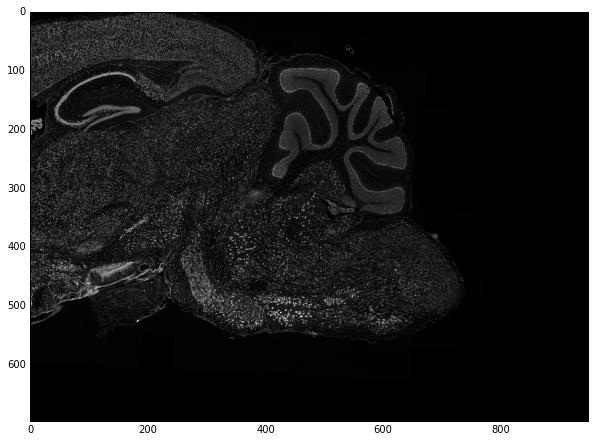

In [10]:
plt.figure(figsize=(10,10));
plt.imshow(img, cmap=plt.cm.gray);
plt.show();

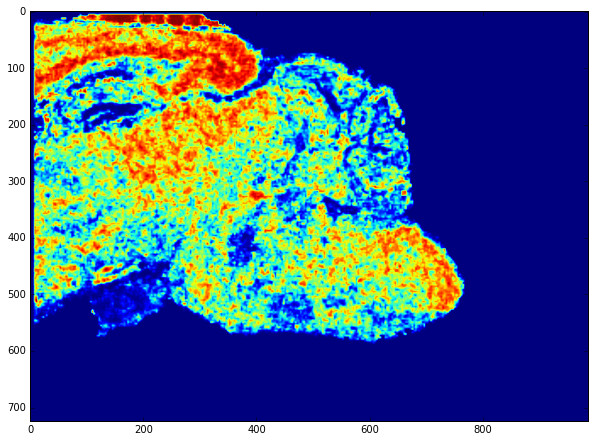

In [20]:
plt.figure(figsize=(10, 10));
plt.imshow(sm);
# plt.colorbar();

In [41]:
display_image(viz)

/home/yuncong/Brain/learning/tmp.jpg

In [13]:
# for stack in ['MD661', 'MD662']:
for stack in ['MD662']:
    for sec in metadata_cache['valid_sections'][stack]:
        if sec < 364:
            continue
    # for sec in [106]:

    #     for structure in clfs.keys():
    #     for structure in ['DC', '5N', '3N', 'Pn', '10N', 'LC', '7N', 'Amb', '12N', 'RMC', 'Sp5O', 'Sp5I', 'Sp5C', 'VCP', 'AP', 'PBG', 'LRt', 'IC', 'VLL', '4N', 'SNC', '6N', 'SNR', 'SC', 'RtTg']:

        compute_and_save_features(
                                scheme='normalize_mu_region_sigma_wholeImage_(-1,5)', 
    #                                 scheme='none', 
    #                             bbox=(11217, 16886, 13859, 18404),
                                win_id=7,
                                stack=stack, sec=sec,
                                model=model, model_name=model_name,
                                 mean_img=mean_img, 
                                 batch_size=batch_size, 
            attach_timestamp=False)

locate patches: 0.10 seconds
Need to compute features at 0 locations.
locate patches: 0.05 seconds


rm -rf "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F143-2017.06.08-00.52.06_MD662_2_0428_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7"
aws s3 cp "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F143-2017.06.08-00.52.06_MD662_2_0428_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F143-2017.06.08-00.52.06_MD662_2_0428_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp"


[Errno 2] No such file or directory: '/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F143-2017.06.08-00.52.06_MD662_2_0428_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp'
No pre-computed features found... computing from scratch.
Not using image_cache.
Load image: 12.00 seconds.
Extract patches: 39.59 seconds


(24126, 1, 224, 224)


Compute features: 39.30 seconds


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F143-2017.06.08-00.52.06_MD662_2_0428_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F143-2017.06.08-00.52.06_MD662_2_0428_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F143-2017.06.08-00.52.06_MD662_2_0428_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_locations.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F143-2017.06.08-00.52.06_MD662_

Save features: 4.25 seconds
locate patches: 0.05 seconds


rm -rf "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F143-2017.06.08-00.52.06_MD662_3_0429_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7"
aws s3 cp "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F143-2017.06.08-00.52.06_MD662_3_0429_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F143-2017.06.08-00.52.06_MD662_3_0429_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp"


[Errno 2] No such file or directory: '/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F143-2017.06.08-00.52.06_MD662_3_0429_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp'
No pre-computed features found... computing from scratch.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD662/MD662_prep2_lossless/MD662&661-F143-2017.06.08-00.52.06_MD662_3_0429_prep2_lossless.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD662/MD662_prep2_lossless"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_prep2_lossless/MD662&661-F143-2017.06.08-00.52.06_MD662_3_0429_prep2_lossless.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD662/MD662_prep2_lossless/MD662&661-F143-2017.06.08-00.52.06_MD662_3_0429_prep2_lossless.tif"


Not using image_cache.
Load image: 19.03 seconds.
Extract patches: 46.61 seconds


(23728, 1, 224, 224)


Compute features: 36.42 seconds


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F143-2017.06.08-00.52.06_MD662_3_0429_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F143-2017.06.08-00.52.06_MD662_3_0429_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F143-2017.06.08-00.52.06_MD662_3_0429_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_locations.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F143-2017.06.08-00.52.06_MD662_

Save features: 4.41 seconds
locate patches: 0.06 seconds


rm -rf "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_1_0430_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7"
aws s3 cp "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_1_0430_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_1_0430_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp"


[Errno 2] No such file or directory: '/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_1_0430_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp'
No pre-computed features found... computing from scratch.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD662/MD662_prep2_lossless/MD662&661-F144-2017.06.08-01.17.04_MD662_1_0430_prep2_lossless.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD662/MD662_prep2_lossless"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_prep2_lossless/MD662&661-F144-2017.06.08-01.17.04_MD662_1_0430_prep2_lossless.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD662/MD662_prep2_lossless/MD662&661-F144-2017.06.08-01.17.04_MD662_1_0430_prep2_lossless.tif"


Not using image_cache.
Load image: 19.45 seconds.
Extract patches: 51.00 seconds


(23375, 1, 224, 224)


Compute features: 37.39 seconds


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_1_0430_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_1_0430_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_1_0430_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_locations.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_

Save features: 4.00 seconds
locate patches: 0.06 seconds


rm -rf "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_2_0431_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7"
aws s3 cp "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_2_0431_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_2_0431_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp"


[Errno 2] No such file or directory: '/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_2_0431_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp'
No pre-computed features found... computing from scratch.
Not using image_cache.
Load image: 12.67 seconds.
Extract patches: 40.75 seconds


(23178, 1, 224, 224)


Compute features: 35.13 seconds


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_2_0431_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_2_0431_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_2_0431_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_locations.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_

Save features: 3.97 seconds
locate patches: 0.05 seconds


rm -rf "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_3_0432_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7"
aws s3 cp "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_3_0432_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_3_0432_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp"


[Errno 2] No such file or directory: '/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_3_0432_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp'
No pre-computed features found... computing from scratch.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD662/MD662_prep2_lossless/MD662&661-F144-2017.06.08-01.17.04_MD662_3_0432_prep2_lossless.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD662/MD662_prep2_lossless"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_prep2_lossless/MD662&661-F144-2017.06.08-01.17.04_MD662_3_0432_prep2_lossless.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD662/MD662_prep2_lossless/MD662&661-F144-2017.06.08-01.17.04_MD662_3_0432_prep2_lossless.tif"


Not using image_cache.
Load image: 18.78 seconds.
Extract patches: 46.03 seconds


(22881, 1, 224, 224)


Compute features: 34.50 seconds


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_3_0432_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_3_0432_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_3_0432_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_locations.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F144-2017.06.08-01.17.04_MD662_

Save features: 3.92 seconds
locate patches: 0.06 seconds


rm -rf "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_1_0433_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7"
aws s3 cp "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_1_0433_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_1_0433_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp"


[Errno 2] No such file or directory: '/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_1_0433_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp'
No pre-computed features found... computing from scratch.
Not using image_cache.
Load image: 13.60 seconds.
Extract patches: 40.15 seconds


(22727, 1, 224, 224)


Compute features: 34.84 seconds


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_1_0433_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_1_0433_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_1_0433_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_locations.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_

Save features: 3.94 seconds
locate patches: 0.05 seconds


rm -rf "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_2_0434_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7"
aws s3 cp "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_2_0434_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_2_0434_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp"


[Errno 2] No such file or directory: '/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_2_0434_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp'
No pre-computed features found... computing from scratch.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD662/MD662_prep2_lossless/MD662&661-F145-2017.06.08-01.42.12_MD662_2_0434_prep2_lossless.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD662/MD662_prep2_lossless"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_prep2_lossless/MD662&661-F145-2017.06.08-01.42.12_MD662_2_0434_prep2_lossless.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD662/MD662_prep2_lossless/MD662&661-F145-2017.06.08-01.42.12_MD662_2_0434_prep2_lossless.tif"


Not using image_cache.
Load image: 21.57 seconds.
Extract patches: 49.18 seconds


(22483, 1, 224, 224)


Compute features: 34.25 seconds


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_2_0434_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_2_0434_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_2_0434_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_locations.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_

Save features: 4.06 seconds
locate patches: 0.06 seconds


rm -rf "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_3_0435_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7"
aws s3 cp "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_3_0435_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_3_0435_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp"


[Errno 2] No such file or directory: '/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_3_0435_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp'
No pre-computed features found... computing from scratch.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD662/MD662_prep2_lossless/MD662&661-F145-2017.06.08-01.42.12_MD662_3_0435_prep2_lossless.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD662/MD662_prep2_lossless"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_prep2_lossless/MD662&661-F145-2017.06.08-01.42.12_MD662_3_0435_prep2_lossless.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD662/MD662_prep2_lossless/MD662&661-F145-2017.06.08-01.42.12_MD662_3_0435_prep2_lossless.tif"


Not using image_cache.
Load image: 20.12 seconds.
Extract patches: 46.75 seconds


(22155, 1, 224, 224)


Compute features: 33.59 seconds


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_3_0435_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_3_0435_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_features.bp"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_3_0435_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7_inception-bn-blue_locations.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD662/MD662_prep2_normalize_mu_region_sigma_wholeImage_(-1,5)_win7/MD662&661-F145-2017.06.08-01.42.12_MD662_

Save features: 3.83 seconds
